# Multi-fidelity Multi-objective Bayesian Optimization

Here we attempt to solve for the constrained Pareto front of the TNK multi-objective
optimization problem using Multi-Fidelity Multi-Objective Bayesian optimization. For
simplicity we assume that the objective and constraint functions at lower fidelities is
exactly equal to the functions at higher fidelities (this is obviously not a
requirement, although for the best results lower fidelity calculations should
correlate with higher fidelity ones). The algorithm should learn this relationship
and use information gathered at lower fidelities to gather samples to improve the
hypervolume of the Pareto front at the maximum fidelity.

TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
%reset -f

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import torch

from xopt import Xopt, Evaluator
from xopt.generators.bayesian import MultiFidelityGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

evaluator = Evaluator(function=evaluate_TNK)
print(tnk_vocs.dict())

{'variables': {'x1': [0.0, 3.14159], 'x2': [0.0, 3.14159]}, 'constraints': {'c1': ['GREATER_THAN', 0.0], 'c2': ['LESS_THAN', 0.5]}, 'objectives': {'y1': 'MINIMIZE', 'y2': 'MINIMIZE'}, 'constants': {'a': 'dummy_constant'}, 'linked_variables': {}}


## Set up the Multi-Fidelity Multi-objective optimization algorithm
Here we create the Multi-Fidelity generator object which can solve both single and
multi-objective optimization problems depending on the number of objectives in VOCS.
We specify a cost function as a function of fidelity parameter $s=[0,1]$ as $C(s) =
s^{3.5}$ as an example from a real life multi-fidelity simulation problem.

In [2]:
options = MultiFidelityGenerator.default_options()
options.acq.reference_point = {"y1":1.5,"y2":1.5}

# set cost function according to approximate scaling of laser plasma accelerator
# problem, see https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.013063
options.acq.cost_function = lambda s: s**3.5
options.optim.num_restarts = 8
options.optim.raw_samples = 512

generator = MultiFidelityGenerator(tnk_vocs, options)
X = Xopt(generator=generator, evaluator=evaluator, vocs=tnk_vocs)

# evaluate at some explicit initial points
X.evaluate_data(pd.DataFrame({"x1":[1.0, 0.75],"x2":[0.75, 1.0],"s":[0.0,0.1]}))

X.generator.options.dict()

{'optim': {'num_restarts': 8,
  'raw_samples': 512,
  'sequential': True,
  'max_travel_distances': None,
  'use_turbo': False},
 'acq': {'proximal_lengthscales': None,
  'use_transformed_proximal_weights': True,
  'monte_carlo_samples': 128,
  'cost_function': <function __main__.<lambda>(s)>,
  'reference_point': {'y1': 1.5, 'y2': 1.5}},
 'model': {'name': 'standard',
  'custom_constructor': None,
  'use_low_noise_prior': True,
  'covar_modules': {},
  'mean_modules': {},
  'fidelity_parameter': 's'},
 'n_initial': 3,
 'use_cuda': False}

## Run optimization routine
Instead of ending the optimization routine after an explict number of samples we end
optimization once a given optimization budget has been exceeded. WARNING: This will
slightly exceed the given budget

In [3]:
budget = 10
while X.generator.calculate_total_cost() < budget:
    X.step()
    print(f"n_samples: {len(X.data)} "
          f"budget used: {X.generator.calculate_total_cost():.4} "
          f"hypervolume: {X.generator.calculate_hypervolume():.4}")

n_samples: 3 budget used: 0.008013 hypervolume: 0.0375
n_samples: 4 budget used: 0.01574 hypervolume: 0.141
n_samples: 5 budget used: 0.02574 hypervolume: 0.141
n_samples: 6 budget used: 0.03422 hypervolume: 0.141
n_samples: 7 budget used: 0.043 hypervolume: 0.2452
n_samples: 8 budget used: 0.0556 hypervolume: 0.2452
n_samples: 9 budget used: 0.06797 hypervolume: 0.2728
n_samples: 10 budget used: 0.07797 hypervolume: 0.3051
n_samples: 11 budget used: 0.09417 hypervolume: 0.3409
n_samples: 12 budget used: 0.125 hypervolume: 0.3877
n_samples: 13 budget used: 0.1761 hypervolume: 0.3877
n_samples: 14 budget used: 0.248 hypervolume: 0.456
n_samples: 15 budget used: 0.3867 hypervolume: 0.456
n_samples: 16 budget used: 0.5125 hypervolume: 0.5342
n_samples: 17 budget used: 0.6926 hypervolume: 0.5936
n_samples: 18 budget used: 0.9339 hypervolume: 0.6966
n_samples: 19 budget used: 1.57 hypervolume: 0.6966
n_samples: 20 budget used: 2.208 hypervolume: 0.8831
n_samples: 21 budget used: 3.111 hyper

## Show results

In [4]:
X.data

,x1,x2,s,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error,a
1,1.000000,0.750000,0.000000,1.000000,0.750000,0.626888,0.312500,"[1, 2, 3]",0.000047,False,NaN
2,0.750000,1.000000,0.100000,0.750000,1.000000,0.626888,0.312500,"[1, 2, 3]",0.000012,False,NaN
3,0.212099,2.127433,0.248935,0.212099,2.127433,3.572866,2.731424,"[1, 2, 3]",0.000040,False,dummy_constant
4,0.963546,0.524984,0.249199,0.963546,0.524984,0.216800,0.215499,"[1, 2, 3]",0.000068,False,dummy_constant
5,0.386722,0.379213,0.268270,0.386722,0.379213,-0.805416,0.027421,"[1, 2, 3]",0.000040,False,dummy_constant
6,0.151933,0.912508,0.255920,0.151933,0.912508,-0.056573,0.291314,"[1, 2, 3]",0.000061,False,dummy_constant
7,0.152166,0.965302,0.258537,0.152166,0.965302,0.035172,0.337495,"[1, 2, 3]",0.000037,False,dummy_constant
8,0.713506,0.751245,0.286583,0.713506,0.751245,-0.018166,0.108709,"[1, 2, 3]",0.000059,False,dummy_constant
9,0.737966,0.764190,0.285025,0.737966,0.764190,0.032455,0.126424,"[1, 2, 3]",0.000042,False,dummy_constant
10,1.034373,0.282907,0.268270,1.034373,0.282907,0.192627,0.332684,"[1, 2, 3]",0.000040,False,dummy_constant


## Plot results
Here we plot the resulting observations in input space, colored by feasibility
(neglecting the fact that
these data points are at varying fidelities).


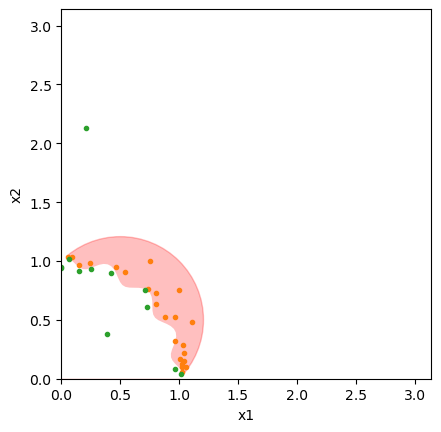

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

theta = np.linspace(0, np.pi / 2)
r = np.sqrt(1 + 0.1 * np.cos(16 * theta))
x_1 = r * np.sin(theta)
x_2_lower = r * np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5) ** 2) ** 0.5 + 0.5

z = np.zeros_like(x_1)

# ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc="white")
circle = plt.Circle(
    (0.5, 0.5), 0.5 ** 0.5, color="r", alpha=0.25, zorder=0, label="Valid Region"
)
ax.add_patch(circle)
history = pd.concat(
    [X.data, tnk_vocs.feasibility_data(X.data)], axis=1, ignore_index=False
)

ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

ax.set_xlim(0, 3.14)
ax.set_ylim(0, 3.14)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_aspect("equal")

### Plot path through input space

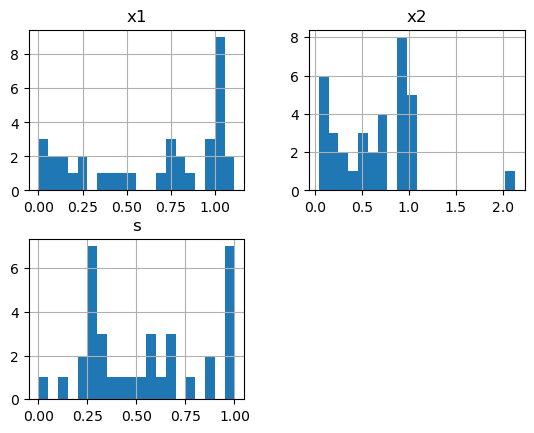

In [6]:
ax = history.hist(["x1", "x2", "s"],bins=20)

<Axes: >

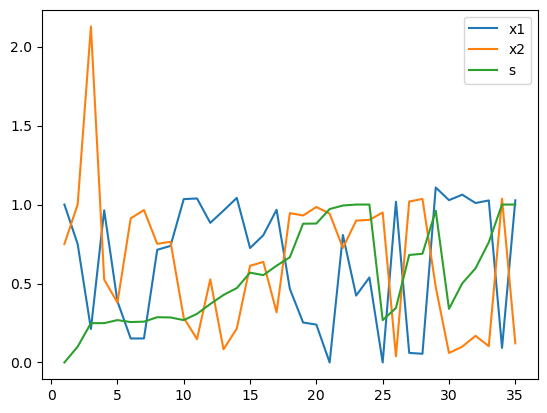

In [7]:
history.plot(y=["x1", "x2", "s"])

## Plot the acqusisition function
Here we plot the acquisition function at a small set of fidelities $[0, 0.5, 1.0]$.

[[0.84151328 0.50533592]]


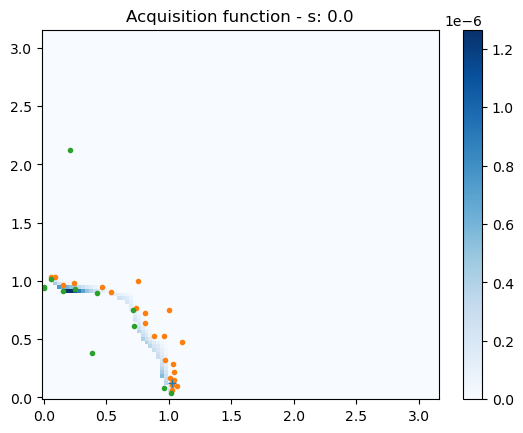

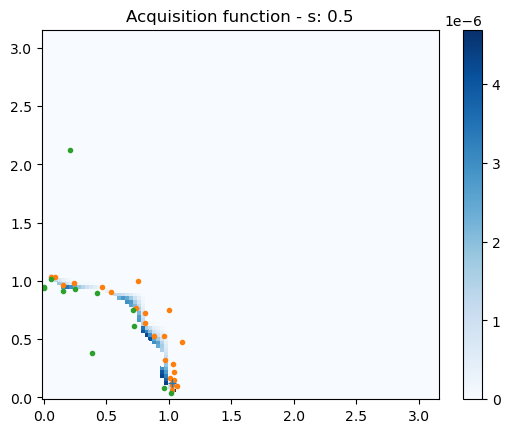

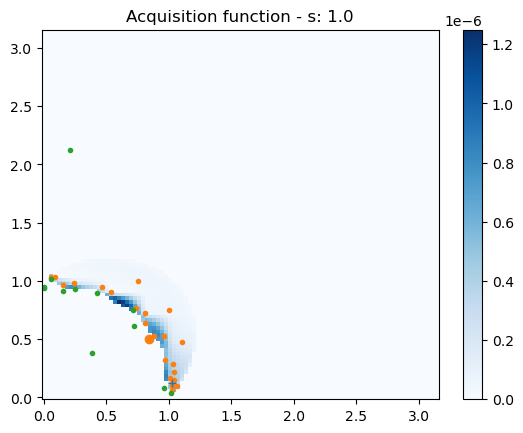

In [8]:
# plot the acquisition function
from xopt.generators.bayesian.objectives import feasibility

bounds = generator.vocs.bounds
model = generator.model

# create mesh over non-fidelity parameters
n = 100
x = torch.linspace(*bounds.T[1], n)
y = torch.linspace(*bounds.T[2], n)
xx, yy = torch.meshgrid(x, y)

# plot function(s) at a single fidelity parameter
fidelities = [0.0, 0.5, 1.0]
for fidelity in fidelities:
    pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()
    pts = torch.cat((torch.ones(pts.shape[0],1)*fidelity, pts), dim=-1)

    acq_func = generator.get_acquisition(model)
    with torch.no_grad():
        acq_pts = pts.unsqueeze(1)
        acq = acq_func(acq_pts)

        fig, ax = plt.subplots()
        c = ax.pcolor(xx, yy, acq.reshape(n, n), cmap="Blues")
        fig.colorbar(c)
        ax.set_title(f"Acquisition function - s: {fidelity}")

        ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
        ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

        ax.plot(*history[["x1", "x2"]].to_numpy()[-1].T, "+")


candidate = generator.generate(1)
print(candidate[["x1", "x2"]].to_numpy())
ax.plot(*candidate[["x1", "x2"]].to_numpy()[0], "o")

In [9]:
# examine lengthscale of the first objective
list(model.models[0].named_parameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([-26.3969], dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant',
  Parameter containing:
  tensor(-0.0623, dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(0.8163, dtype=torch.float64, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[0.7762, 1.3692, 1.3992]], dtype=torch.float64, requires_grad=True))]

In [10]:
# dump results to fiel
X.options.dump_file = "results.yaml"
X.dump_state()